In [2]:
%matplotlib inline 
import math
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F
import torch
from typing import Tuple,List,Dict,Callable
from torch import Tensor

#批次为32 ， 时间步为35
batch_size , num_steps = 32 , 35
train_iter , vocab =  d2l.load_data_time_machine( batch_size , num_steps )

In [3]:
now_device = d2l.try_gpu()

## 8.5.1 独热编码

In [4]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [5]:
# x = torch.randint( 0 , 3 , ( 2,5 ))
# x

In [6]:
# x_onehot =  F.one_hot( x.T  ,28)#注意如果没有指定元素个数1的话，会自动匹配多少个元素，比如说这里有0 1 2 这三个元素，那就需要3个维度，最后得到一个2*3的形状
# x_onehot , x_onehot.shape #维度为：批次 * 长度 * 元素个数

In [7]:
# #我们需要得到一个 （时间步数, 批量大小, 词汇表大小）的输出
# x_onehot =  F.one_hot( x.T  )
# print( x_onehot )
# for x in x_onehot:
#     print( x )

In [8]:
def get_params( vocab_size ,num_hiddens , device ):
    num_inputs = num_outputs  = vocab_size
    def normal( shape ):
        return torch.randn( size=shape , device = device) * 0.01
    
    #隐藏层参数
    #输入与权值参数相乘
    w_xh = normal( (num_inputs , num_hiddens) )
    #上次的隐藏变量与权值参数相乘
    w_hh = normal( (num_hiddens , num_hiddens) )
    #偏置
    b_hh = torch.zeros( num_hiddens , device = device )

    #输出层参数
    w_hq = normal( (num_hiddens , num_outputs) )
    b_hq = torch.zeros( num_outputs , device= device  )

    #将参数组装成一个列表
    params = [ w_xh , w_hh , b_hh , w_hq , b_hq ]
    #保留梯度参数
    for param in params:
        param.requires_grad_( True )
    return params
    

In [9]:
#保留隐藏状态，返回一个元组,函数的返回是一个张量，张量全用0填充，形状为（批量大小, 隐藏单元数）。
#在后面的章节中将会遇到隐藏状态包含多个变量的情况，而使用元组可以处理地更容易些。
def init_rnn_state( batch_size , num_hiddens  , device ):
    return (torch.zeros( (batch_size , num_hiddens) , device = device ) , )

In [10]:
def rnn( inputs ,  state , params ):
    # `inputs`的形状：(`时间步数量`，`批量大小`，`词表大小`)，逐时间步更新参数
    w_xh,  w_hh , b_h , w_hq , b_q = params
    H, = state
    outputs = []
    # X 的形状为( 批量大小 ， 词表大小)
    for X in inputs:
        H = torch.tanh( torch.mm( X , w_xh ) + torch.mm( H , w_hh ) + b_h )
        Y = torch.mm( H , w_hq ) + b_q
        outputs.append( Y )
    #以行堆叠数据,返回输出序列 和当前隐藏状态
    return torch.cat( outputs , dim=0 ) , ( H , )

In [11]:
#使用一个类去包装当前函数
class RNNModelScratch:
    def __init__( self , vocab_size,  num_hiddens , device , get_params , init_state , forward_fn ):
        #得到词表大小和隐藏状态的张量大小
        self.vocab_size ,  self.num_hiddens = vocab_size , num_hiddens
        self.params = get_params( vocab_size , num_hiddens , device )
        self.init_state, self.forward_fn = init_state, forward_fn
    #这里我们使用__call__魔法方法将类可以当做函数进行使用，类似于forward,最后返回的是一个集成了输出和隐藏状态的元祖
    def __call__(self, X , state ) :
        X = F.one_hot( X.T , self.vocab_size ).type( torch.float32 )
        return self.forward_fn( X , state , self.params )
    
    def begin_state( self , batch_size , device ):
        return self.init_state(batch_size, self.num_hiddens, device)
        

In [12]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape , X

(torch.Size([5, 2, 28]),
 tensor([[0, 1, 2, 3, 4],
         [5, 6, 7, 8, 9]]))

In [13]:
num_hiddens = 512 
net = RNNModelScratch( len( vocab ) , num_hiddens , d2l.try_gpu() , 
                      get_params , init_rnn_state , rnn )
state = net.begin_state( X.shape[0] , d2l.try_gpu() )
Y , new_state = net( X.to( d2l.try_gpu() ) , state )
Y.shape , new_state[0].shape

(torch.Size([10, 28]), torch.Size([2, 512]))

In [14]:
x_test = torch.Tensor([[1 , 0 , 0] ])
(x_test.argmax(dim=1)).item()

0

In [15]:
def predict_ch8( prefix , num_preds , net ,  vocab , device ):
    #准备一个词元一个词元进行预热
    state = net.begin_state( batch_size=1 , device = device  )
    #因为第一个词元已经作为输入了，这里将第一个词元的索引直接放入输出列表里
    outputs = [vocab[ prefix[0] ]]
    #使用匿名函数得到输入列表的最后一个元素,这里转成二维是因为输入需要二维( 批次 , 时间步)
    get_input = lambda :torch.tensor( [outputs[-1]] , device = device ).reshape( (1,1))
    #预热期
    for y in prefix[1:]:
        #就是用每一个输入词元去更新state
        _ , state = net( get_input() , state )
        #将输入字符的索引添加到outputs
        outputs.append( vocab[y] )
    for _ in range( num_preds ):
        Y , state = net( get_input() , state )
        outputs.append(  int( Y.argmax( dim=1 ).reshape(1) ) )
    #对可迭代器中的str进行连接
    return ''.join( [ vocab.idx_to_token[i] for i in outputs ] )


In [16]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller nhlomfixfi'

In [17]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度。"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    #为了看得清楚，我特意加了个列表，实际上sum内部也可以不用列表生成式
    norm = torch.sqrt(  sum( [torch.sum((p.grad ** 2)) for p in params]  )   )
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [18]:
#这段是我的测试代码，想看看nn.CrossEntropyLoss是不是跟我的想的一样，结果是的，具体参看我的知乎收藏
for X,y in train_iter:
    print( X , X.shape )
    y = y.T.reshape(-1)
    y = y.to( now_device )
    state = net.begin_state(batch_size=X.shape[0], device= now_device)
    Y , _ = net( X.to( now_device ) , state )
    loss = nn.CrossEntropyLoss()
    l = loss( Y , y )
    print( y.long() , y.shape )
    print( Y , Y.shape , l)
    break

tensor([[ 1, 17,  2,  ...,  1,  5,  3],
        [ 3,  1, 16,  ...,  2,  8,  1],
        [10,  1,  4,  ...,  8,  1,  2],
        ...,
        [ 8,  1,  4,  ...,  3,  1, 21],
        [ 4,  6,  8,  ...,  6, 11,  1],
        [20, 12,  4,  ...,  1, 14, 20]]) torch.Size([32, 35])
tensor([17,  1,  1,  ..., 14,  6,  1], device='cuda:0') torch.Size([1120])
tensor([[-0.0002,  0.0013,  0.0020,  ...,  0.0011, -0.0008,  0.0007],
        [ 0.0044,  0.0012, -0.0016,  ..., -0.0007, -0.0015,  0.0004],
        [ 0.0017, -0.0007,  0.0019,  ...,  0.0022,  0.0012, -0.0009],
        ...,
        [-0.0010,  0.0024,  0.0054,  ..., -0.0030, -0.0004, -0.0013],
        [-0.0007,  0.0021,  0.0027,  ...,  0.0010, -0.0016,  0.0014],
        [ 0.0037,  0.0045,  0.0007,  ...,  0.0036, -0.0031, -0.0045]],
       device='cuda:0', grad_fn=<CatBackward>) torch.Size([1120, 28]) tensor(3.3322, device='cuda:0', grad_fn=<NllLossBackward>)


In [19]:
#训练四个要素：网络，数据集，目标函数。优化器
def train_epoch_ch8( net  , train_iter , loss , updater , device , use_random_iter  ):
    state , timer = None , d2l.Timer()
    metric = d2l.Accumulator( 2 )#存储训练损失之和，词元数量
    for X,Y in train_iter:
        if state is None or use_random_iter:
            #第一次的隐藏状态需要初始化。如果说使用的是随机抽样的话，每个批次的数据是不相邻的，不相邻的话上一批次的隐藏状态
            #就没办法作为下一次来训练，所以这里在之后的训练中需要对隐藏状态重新初始化。
            state = net.begin_state( batch_size  = X.shape[0] , device = device )
        else:
            #这一步是要分离计算图，就是不计算梯度，节省时间
            #这一次是要state对nn.GRU进行分离
            if isinstance( net , nn.Module ) and not isinstance(state, tuple):
                state.detach_()
            else:
                #这个是对LSTM进行分离
                for s in state:
                    s.detach_()
        #这一步是要获得总标签，实际上也是nn.CrossEntropyLoss()的用法，就是标签可以采用一维张量，但是预测值需要二维及以上张量
        y = Y.T.reshape( -1 )
        X ,y = X.to( device ) , y.to( device )
        y_hat , state = net( X , state )
        #实际上如果采用CrossEntropyLoss会自动求平均的
        l = loss( y_hat , y.long() ).mean()
        if isinstance( updater , torch.optim.Optimizer ):
            updater.zero_grad()
            l.backward()
            grad_clipping( net , 1 )
            updater.step()
        else:#那如果采用自己写的sgd函数
            l.backward()
            grad_clipping( net , 1 )
            # 这里批次数据等于1是因为d2l.sgd函数中对步长使用batch_size进行了归一化，也就是说d2l.sgd函数当初是针对
            # 没有平均的目标函数使用的，由全体batch_size的全体loss.sum()当然要在梯度更新的时候除以batch_size，
            # 如果是nn.CrossEntropyLoss()就已经平均过的loss值就没必要再除掉batch_size
            updater( batch_size = 1  )
        #这里就不解释了，累计loss，得到一个epoch的loss后除掉总体样本，得到平均loss
        metric.add( l * y.numel() , y.numel() )
    #这里再看看训练一个epoch中每个样本平均训练时间
    return math.exp( metric[0] / metric[1] )  , metric[1]/timer.stop() 

In [20]:
#谨记：训练四要素：网络，数据集，目标函数，优化器。
#谨记：主要三种超参数：lr , batch_size , epochs
def train_ch8( net , train_iter , vocab , lr , num_epochs , device , use_random_iter = False  ):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    if isinstance(  net , nn.Module ):
        updater = torch.optim.SGD( net.parameters() , lr = lr  )
    else:
        updater = lambda batch_size:d2l.sgd( net.params , lr , batch_size )
    predict = lambda prefix:predict_ch8( prefix , 50 , net , vocab , device  )
    # train start!
    for epoch in range(   num_epochs  ):
        ppl , speed = train_epoch_ch8( net , train_iter ,loss , updater , device , use_random_iter )
        if (epoch+1)%10 == 0 :
            print(predict('time traveller'))
            animator.add( epoch+1 , [ppl] )
    print( f'困惑度：{ ppl:2f} , speed:{speed:.2f}词元/秒 { str(device) }')
    print(predict('time traveller'))
    print(predict('traveller'))

KeyboardInterrupt: 

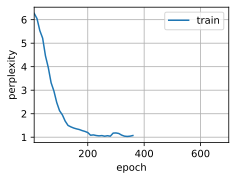

In [22]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab , lr , num_epochs , d2l.try_gpu()  )  

困惑度：1.325127 , speed:27740.72词元/秒 cuda:0
time travellerit s against reason said filbywhat only anouthin t
traveller after the pauserequired for the proper assimilati


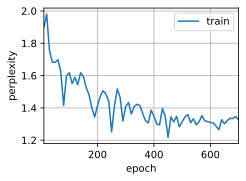

In [23]:
train_ch8( net , train_iter , vocab , lr , num_epochs , now_device , use_random_iter= True )

### 随机抽样好像不太行啊